In [12]:
import random, matplotlib.pyplot as plt, time, math, multiprocessing, concurrent.futures
import numpy as np

gamma,Radius_of_circle=1,1
sigma,drift,potential_constant,time2=0.8,0.3,1,20

num_points_k,N=100,20
start_k=-1
end_k=1

num_points_j=100
start_j=-1
end_j=1.5

def scgf(sigma,drift,potential_constant):
    lamx=[]
    lamy=[]
    for i in range(num_points_k):
        k=start_k+(end_k-start_k)/num_points_k*i
        
        mat=np.zeros((2*N+1+2,2*N+1+2), dtype=complex)
        
        for i in range(1,len(mat)-1):
            mat[i,i]=(drift+k*sigma**2)*(-N+i-1)*1j-sigma**2*(-N+i-1)**2/2+k*drift+k**2*sigma**2/2
            mat[i,i-1]=potential_constant/2*(-N+i-1-1-k*1j)
            mat[i,i+1]=potential_constant/2*(N-i+1-1+k*1j)
        
        a=np.linalg.eigvals(mat[1:-1,1:-1])
        b=[]
        for i in range(len(a)):
            if abs(a[i].imag)<1e-7:
                b.append(a[i].real)
        
        lamx.append(k)
        lamy.append(b[0])
    
    return [lamx,lamy]

def ratefn(sigma,drift,potential_constant):
    Ix=[]
    Iy=[]
    for i in range(num_points_j):
        j=start_j+(end_j-start_j)/num_points_j*i
        
        Ix.append(j)
        Iy.append(max(np.array(scgf(sigma,drift,potential_constant)[0])*j-scgf(sigma,drift,potential_constant)[1]))
        
    return [Ix,Iy]




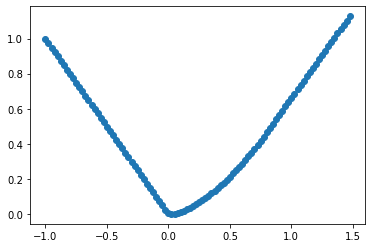

In [13]:
arr=ratefn(sigma,drift,potential_constant)
plt.scatter(arr[0],arr[1])

In [23]:
(np.exp(arr[1]))**(-1)

array([0.36852116, 0.37785032, 0.38741565, 0.39722312, 0.40727887,
       0.41758918, 0.4281605 , 0.43899944, 0.45011276, 0.46150742,
       0.47319054, 0.48516941, 0.49745154, 0.51004458, 0.52295642,
       0.53619513, 0.54976897, 0.56368644, 0.57795623, 0.59258726,
       0.60758868, 0.62296986, 0.63874042, 0.65491021, 0.67148934,
       0.68848817, 0.70591733, 0.72378771, 0.74211049, 0.7608971 ,
       0.7801593 , 0.79990913, 0.82015893, 0.84092135, 0.86220938,
       0.88403631, 0.90641579, 0.92936182, 0.95288873, 0.9768265 ,
       0.99664966, 0.99998847, 0.99801902, 0.99377495, 0.98801259,
       0.98109345, 0.97322595, 0.96457399, 0.95521577, 0.94525546,
       0.93472654, 0.92374107, 0.91230424, 0.90041723, 0.88817022,
       0.87558781, 0.86269324, 0.84950852, 0.83603236, 0.82227762,
       0.80829295, 0.79409602, 0.77970403, 0.7651339 , 0.75038439,
       0.7354439 , 0.72037384, 0.70519079, 0.68990182, 0.67446607,
       0.65896744, 0.64342221, 0.62784991, 0.61265449, 0.59782

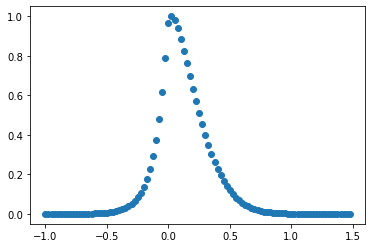

In [31]:
plt.scatter(arr[0],(np.exp(arr[1]))**(-10))

In [50]:
def flatten(xss):
    return [x for xs in xss for x in xs]


ram0=1024
def brownian_v3(iterations):
    #gamma=1.380649*(10**(-23))*300/diffusion
    pos=np.zeros((iterations,ram0))
    cur=np.zeros((iterations,ram0))
    A=np.zeros(ram0)
    B=np.zeros(ram0)
    C=[sigma, drift, potential_constant, iterations,time2]
    intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi
    #intial_pos=1.0
    theta0=np.full(ram0,intial_pos) 
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=np.pi/2
    theta=np.full(ram0,theta0)
    theta2=np.zeros(ram0)
    dt=0.1 #time increment
    T=int(time2/dt) #Total time
    std=np.sqrt(dt*sigma)
    
    prefactor=1/(gamma*Radius_of_circle)
    for n in range(iterations):
        #D=np.zeros(T)
        #D[0]=intial_pos
        
        for i in range(T):
            #D[i]=theta[0]-theta0[0]
            theta+=prefactor*(np.random.normal(0,std, ram0)+(drift-potential_constant*(-np.sin(theta))/Radius_of_circle)*dt)
            
        theta2=theta-np.floor((theta-np.pi)/(2*np.pi))*2*np.pi-2*np.pi
        
        pos[n]=theta2
        cur[n]=Radius_of_circle*(theta-theta0)/time2
        
        theta=np.full(ram0,theta0)

    pos=pos.flatten()
    cur=cur.flatten()


    return pos,cur #D

if __name__ == "__main__":
    iterations=10**2
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        start_time = time.perf_counter()
        temp = list(executor.map(brownian_v3, [10 for i in range(int(iterations/10))]))
        finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    

results = [[temp[j][i] for j in range(len(temp))] for i in range(len(temp[0]))]
pos = flatten(results[0])
cur = flatten(results[1])

print(len(cur))


Program finished in 0.159522685000411 seconds
102400


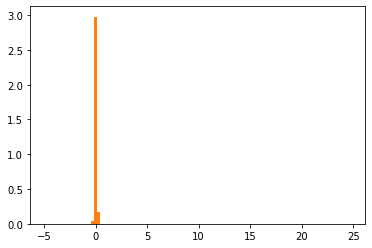

In [51]:
bins_manual=[]
for i in range(-15,80):
    bins_manual.append((2*np.pi*i-np.pi)/time2)
    
pj=plt.hist(cur, bins=bins_manual, density=True)[0]
pjx=plt.hist(cur, bins=bins_manual, density=True)[1]
pjj=[]
pjjx=[]
for i in range(len(pj)-1):
    if pj[i]!=0:
        pjj.append(pj[i])
        pjjx.append((pjx[i+1]+pjx[i])/2)
pj2=(-1/time2)*np.log(pjj)

Area2=0
for i in range(len(pjjx)):
    Area2+=pjj[i]

Area=np.sum(pj)*(pjx[2]-pjx[1])
    
#Don't divide by area or area2. Useless


pj2=(-1/time2)*np.log(pjj)

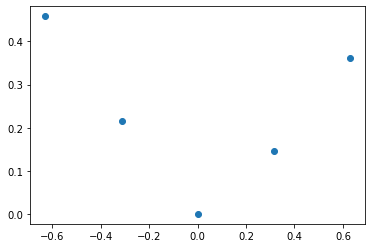

In [52]:
plt.scatter(pjjx,pj2-min(pj2))

<function matplotlib.pyplot.show(close=None, block=None)>

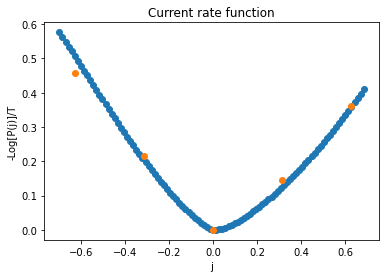

In [55]:
arr=ratefn(sigma,drift,potential_constant)
plt.scatter(arr[0],arr[1])

plt.scatter(pjjx,pj2-min(pj2))
#plt.scatter(pjjx-(pjjx[np.argmin(pj2)]-arr[0][np.argmin(arr[1])]),pj2-min(pj2))
plt.title('Current rate function')
plt.xlabel('j')
plt.ylabel('-Log[P(j)]/T')

plt.show

In [47]:
pjjx[np.argmin(pj2)]
arr[0][np.argmin(arr[1])]

0.009400000000000002

In [46]:
arr

[[-0.02,
  -0.0193,
  -0.0186,
  -0.0179,
  -0.0172,
  -0.0165,
  -0.0158,
  -0.015099999999999999,
  -0.0144,
  -0.0137,
  -0.013,
  -0.012299999999999998,
  -0.0116,
  -0.0109,
  -0.010199999999999999,
  -0.009499999999999998,
  -0.008799999999999999,
  -0.0081,
  -0.007399999999999999,
  -0.006699999999999998,
  -0.005999999999999998,
  -0.005299999999999999,
  -0.004599999999999998,
  -0.0038999999999999972,
  -0.003199999999999998,
  -0.0024999999999999988,
  -0.0017999999999999995,
  -0.0010999999999999968,
  -0.0003999999999999976,
  0.00030000000000000165,
  0.0010000000000000044,
  0.0017000000000000036,
  0.002400000000000003,
  0.003100000000000002,
  0.0038000000000000013,
  0.004500000000000004,
  0.005200000000000003,
  0.0059000000000000025,
  0.006600000000000005,
  0.007300000000000004,
  0.008000000000000004,
  0.008700000000000003,
  0.009400000000000002,
  0.010100000000000005,
  0.010800000000000004,
  0.011500000000000007,
  0.012200000000000006,
  0.0129000000000

In [38]:
np.real_if_close(np.linalg.eigvals(mat[1:-1,1:-1]))

NameError: name 'mat' is not defined

In [187]:
a=np.linalg.eigvals(mat[1:-1,1:-1])
b=[]
for i in range(len(a)):
    if abs(a[i].imag)<1e-10:
        b.append(a[i].real)
        
print(b)

[0.000986567937507266]


In [225]:
max(np.linalg.eigvals(mat[1:-1,1:-1]).real)

-0.0005375698527851891

In [81]:
k*drift+k**2*sigma**2/2

0.125

In [94]:
mat[1:-1,1:-1]

array([[ 0.125+0.j  , -0.   +0.j  ,  0.   +0.j  ],
       [ 0.   +0.j  ,  0.   +0.25j, -0.   +0.j  ],
       [ 0.   +0.j  ,  0.   +0.j  , -0.375+0.5j ]])

In [106]:
np.linalg.eigvals(mat[1:-1,1:-1]).imag

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])

In [143]:
np.real_if_close(0.53332514+8.91487462e-1j)

array(0.53332514+0.89148746j)

In [ ]:
k=-2

N=30
mat=np.zeros((2*N+1+2,2*N+1+2), dtype=complex)

for i in range(1,len(mat)-1):
    mat[i,i]=(drift+k*sigma**2)*(-N+i-1)*1j-sigma**2*(-N+i-1)**2/2+k*drift+k**2*sigma**2/2
    mat[i,i-1]=potential_constant/2*(-N+i-1-1-k*1j)
    mat[i,i+1]=potential_constant/2*(N-i+1-1+k*1j)



a=np.linalg.eigvals(mat[1:-1,1:-1])
b=[]
for i in range(len(a)):
    if abs(a[i].imag)<1e-10:
        b.append(a[i].real)
        
print(b[0])